In [31]:
!pip uninstall jupyterlab_git

^C


## Step 0: Preprocessing the input

In [1]:
import glob
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
from PIL import Image
from PIL import ImageOps
import random
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Hyper-parameters
latent_size = 100
hidden_size = 256
image_size = 3*64*64
num_epochs = 25
batch_size = 6
discriminator_iteration = 1
generator_iteration = 1
sample_dir = './Sample Images'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def convertbg(img):
    img = img.convert("RGBA")
    datas = img.getdata()
 
    newData = []
 
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
 
    img.putdata(newData)
    img = img.convert('RGB')
    return img

class PokemonDataset(Dataset):
    "Pokemon Dataset to be added into a dataloader"
    def __init__(self):
        normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64,64)),
            transforms.Normalize(*normalization_stats)
        ])
        
        self.spritesList = list()

        versions = ['black-white','emerald','platinum']

        for ver in versions:
            images = glob.glob("./Pokemon/main-sprites/"+ ver +"/*.png")
            for image in images:
                with open(image, 'rb') as file:
                    img = Image.open(file)
                    mirror_img = ImageOps.mirror(img)
                    img = img.convert('RGB')
                    mirror_img = mirror_img.convert('RGB')
                    if ver == 'crystal' or ver == 'yellow':
                        img = convertbg(img)
                        mirror_img = convertbg(img)
                    img = transform(img)
                    mirror_img = transform(mirror_img)
                    self.spritesList.append(img)
                    self.spritesList.append(mirror_img)

        #Do colour transformation for the images
        color_transform = transforms.Compose([
            transforms.ColorJitter(0.5, 0.5, 0.5)
        ])

        color_sprites = list()
        for idx, (image) in enumerate(self.spritesList):
            c_image = color_transform(image)
            color_sprites.append(c_image)

        self.spritesList = self.spritesList + color_sprites

        #Gaussian Blur the images as well
        g_transform = transforms.Compose([
            transforms.GaussianBlur(3)
        ])

        blur_sprites = list()
        for idx, (image) in enumerate(self.spritesList):
            g_image = g_transform(image)
            blur_sprites.append(g_image)
        
        self.spritesList = self.spritesList + blur_sprites
        random.shuffle(self.spritesList)
        
        indexed_spritesList = list()
        for i in range(len(self.spritesList)):
            indexed_spritesList.append((self.spritesList[i],i))
            
        self.spritesList = indexed_spritesList
    
    def __len__(self):
        return len(self.spritesList)
    
    def __getitem__(self,idx):
        return self.spritesList[idx]

PokemonData = PokemonDataset()

## Step 1: The forward process = Noise scheduler

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.00005, end=0.02):
    return torch.linspace(start, end, timesteps)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


Applying it to the input data

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

dataloader = DataLoader(PokemonData, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

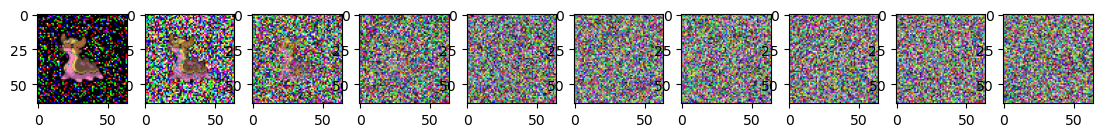

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images+1), int((idx/stepsize) + 1))
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The Backward Process = U-Net

In [5]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [21]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images), num_images - int(i/stepsize))
            show_tensor_image(img.detach().cpu())
    plt.show()           

Epoch 0 | step 000 Loss: 0.07048547267913818 


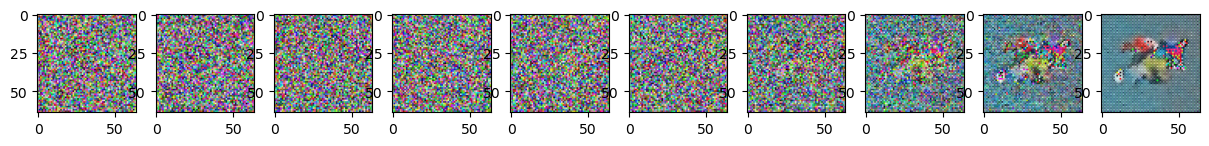

Epoch 5 | step 000 Loss: 0.07041677832603455 


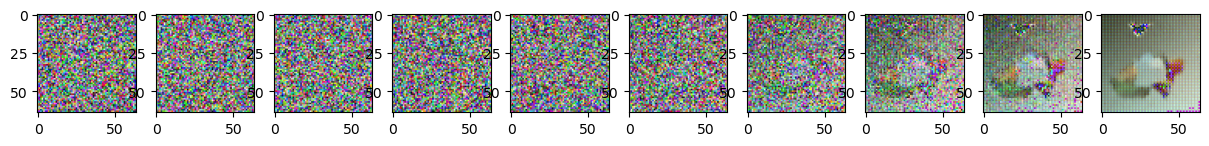

Epoch 10 | step 000 Loss: 0.06872835010290146 


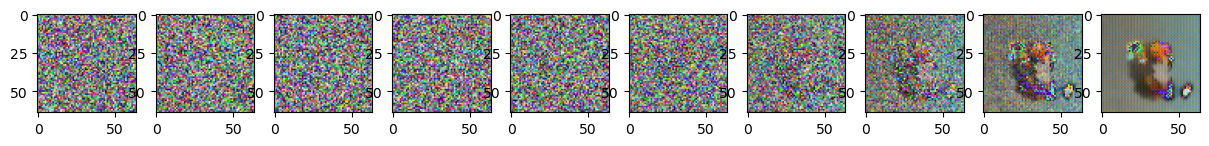

Epoch 15 | step 000 Loss: 0.06763820350170135 


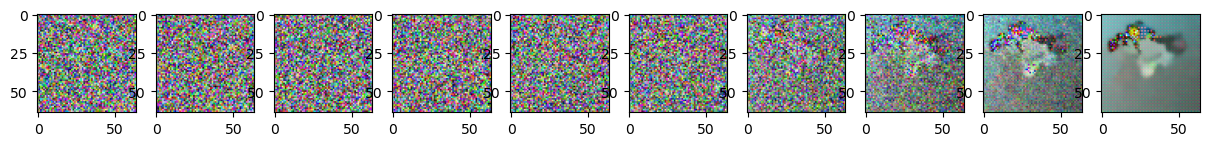

Epoch 20 | step 000 Loss: 0.0643441379070282 


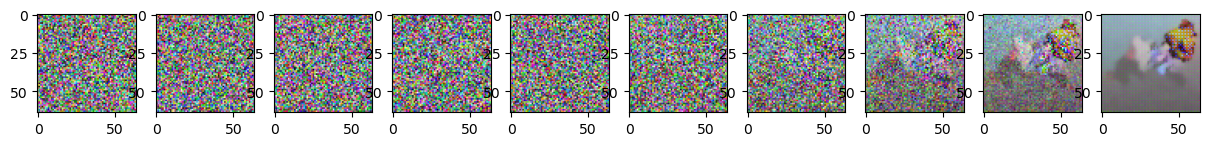

Epoch 25 | step 000 Loss: 0.08158702403306961 


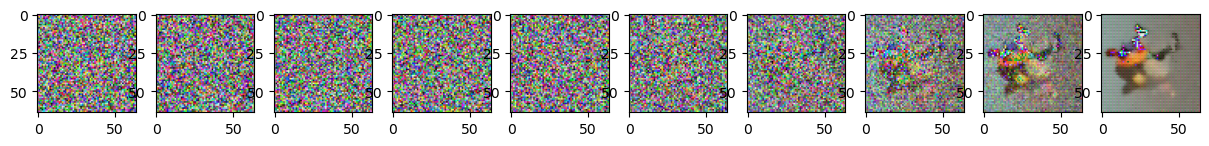

Epoch 30 | step 000 Loss: 0.06805583834648132 


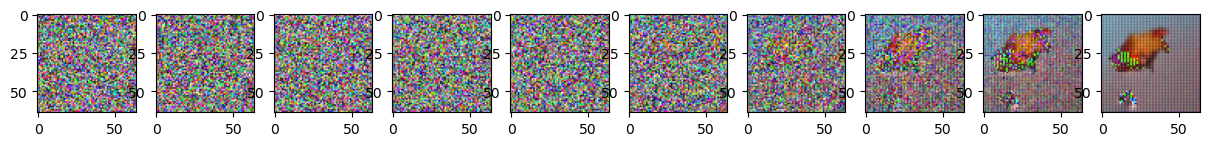

Epoch 35 | step 000 Loss: 0.07098575681447983 


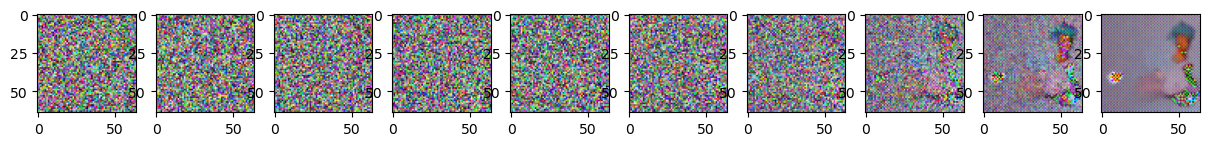

KeyboardInterrupt: 

In [25]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!
model.load_state_dict(torch.load('model_diffusion.ckpt'))

for epoch in range(epochs): 
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
            torch.save(model.state_dict(), 'model_diffusion.ckpt')
